In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
import shap

In [ ]:
import pandas as pd
# Replace with your bucket and file path
file_path = '/content/crime2017-2024.csv'

import dask.dataframe as dd
ddf = dd.read_csv(file_path)  # Remove storage_options as it is a local file path

In [ ]:
ddf.compute().shape

(1873724, 28)

In [ ]:
ddf['Latitude']= ddf['Latitude'].astype('float32')
ddf['Hour']= ddf['Hour'].astype('int8')
ddf['Longitude']= ddf['Longitude'].astype('float32')
ddf['Year']= ddf['Year'].astype('int16')
ddf['Month']= ddf['Month'].astype('int8')
ddf['Day_of_Week']= ddf['Day_of_Week'].astype('int8')
ddf['Arrest']= ddf['Arrest'].astype('int8')

In [ ]:

# Define group columns for spatial and temporal aggregation
group_cols = ['ZIP', 'Hour', 'Day_of_Week', 'Month']

# Create crime count as a proxy for likelihood
# Assuming your Dask DataFrame is named 'ddf'
crime_counts = ddf.groupby(group_cols)['ID'].count().reset_index()
crime_counts = crime_counts.rename(columns={'ID': 'Crime_Count'})

# Merge crime counts back into the original DataFrame
ddf = dd.merge(ddf, crime_counts, on=group_cols, how='left')

# Optional: Create a binary likelihood target
threshold = ddf['Crime_Count'].mean().compute()  # Compute mean count as threshold
ddf['Crime_Likelihood'] = (ddf['Crime_Count'] > threshold).astype(int)

In [ ]:
import dask.dataframe as dd
import pandas as pd
import numpy as np
from sklearn.feature_selection import mutual_info_classif, f_classif
from sklearn.preprocessing import LabelEncoder
from scipy.stats import chi2_contingency


# Define numerical and categorical features
numerical_features = ['Latitude', 'Longitude', 'Hour', 'Day_of_Week', 'Month', 'Is_Weekend', 'ZIP']
categorical_features = ['FBI Code', 'Arrest', 'Domestic']
target_columns = ['Encoded_Crime_Type', 'Encoded_Crime_Severity', 'Crime_Likelihood']


# Encode categorical features and targets
label_encoders = {}
for col in categorical_features + target_columns:
    label_encoders[col] = LabelEncoder()
    ddf[col] = ddf[col].map_partitions(lambda x: label_encoders[col].fit_transform(x.astype(str)))

# Compute correlations for each target
correlation_results = {}

# Function to compute Cramér's V
def cramers_v(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    return np.sqrt(chi2 / (n * (min(confusion_matrix.shape) - 1)))
for target in target_columns:
    print(f"\nAnalyzing correlations with target: {target}\n")
    results = []

    # Numerical Features: Compute F-Score and Mutual Information
    for feature in numerical_features:
        # Convert to pandas for F-Score computation
        feature_data = ddf[[feature, target]].dropna().compute()  # Compute Dask DataFrame to Pandas

        # Use feature_data[feature] directly instead of feature_data[[feature]]
        f_score = f_classif(feature_data[feature].values.reshape(-1, 1), feature_data[target])[0][0]
        mi = mutual_info_classif(feature_data[feature].values.reshape(-1, 1), feature_data[target], discrete_features=False)[0]
        results.append((feature, "Numerical", f_score, mi))

    # Categorical Features: Compute Cramér's V
    for feature in categorical_features:
        # Convert to pandas for categorical correlation computation
        feature_data = ddf[[feature, target]].dropna().compute()  # Compute Dask DataFrame to Pandas

        contingency_table = pd.crosstab(feature_data[feature], feature_data[target])
        cramers_v_score = cramers_v(contingency_table.to_numpy())
        mi = mutual_info_classif(feature_data[feature].values.reshape(-1, 1), feature_data[target], discrete_features=True)[0]
        results.append((feature, "Categorical", cramers_v_score, mi))

    # Store results in a DataFrame
    correlation_df = pd.DataFrame(results, columns=['Feature', 'Type', 'Correlation (F-Score or Cramér\'s V)', 'Mutual Information'])
    correlation_results[target] = correlation_df.sort_values(by='Correlation (F-Score or Cramér\'s V)', ascending=False)
    print(correlation_results[target])




Analyzing correlations with target: Encoded_Crime_Type



KeyboardInterrupt: 

In [ ]:
selected_features = [
    'Latitude', 'Longitude', 'FBI Code', 'Hour', 'Is_Weekend', 'Arrest', 'ZIP'
]

target_columns = ['Encoded_Crime_Type', 'Encoded_Crime_Severity', 'Crime_Likelihood']




In [ ]:
X = ddf[selected_features]
y = ddf[target_columns]


In [ ]:
# Split into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(
    X.compute(), y.compute(), test_size=0.3, stratify=y['Encoded_Crime_Type'].compute(), random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp['Encoded_Crime_Type'], random_state=42
)

print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

Training set size: 1311606
Validation set size: 281059
Test set size: 281059


In [ ]:
# Encode the 'FBI Code' column using LabelEncoder
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
X_train['FBI Code'] = encoder.fit_transform(X_train['FBI Code'].astype(str))  # Fit and transform on training data
X_val['FBI Code'] = encoder.transform(X_val['FBI Code'].astype(str))  # Transform validation data
X_test['FBI Code'] = encoder.transform(X_test['FBI Code'].astype(str))  # Transform test data

In [ ]:
xgb_model = MultiOutputClassifier(
    XGBClassifier(
        n_estimators=100,
        max_depth=5,
        learning_rate=0.1,
        tree_method='gpu_hist',
        random_state=42
    )
)
# Train the model
xgb_model.fit(X_train, y_train)


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:54:43] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:54:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:54:47] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserW

MultiOutputClassifier(estimator=XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None,
                                              feature_types=None, gamma=None,
                                              grow_policy=None,
                                              importance_type=None,
                                              interaction_constraints=None,
                                              learning_rate=0.1, max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None, max_depth=5,
                                              max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=100, n_jobs=None,
                                              num_parallel_tree=None,
                                              random_state=42, ...))

In [ ]:
from sklearn.metrics import classification_report

y_val_pred = xgb_model.predict(X_val)
# Evaluate for each target variable
for i, target in enumerate(target_columns):
    print(f"Validation Report for {target}:")
    print(classification_report(y_val.iloc[:, i], y_val_pred[:, i]))
# Predict on test set
y_test_pred = xgb_model.predict(X_test)
# Evaluate on test set
for i, target in enumerate(target_columns):
    print(f"Test Report for {target}:")
    print(classification_report(y_test.iloc[:, i], y_test_pred[:, i]))



/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:54:47] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:54:47] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:54:47] WARNING: /workspace/src

Validation Report for Encoded_Crime_Type:
              precision    recall  f1-score   support

           0       0.98      0.77      0.87      3960
           1       0.82      0.36      0.51       206
           2       0.72      0.81      0.76     18704
           3       1.00      0.97      0.98    148546
           4       0.88      0.54      0.67      2401
           5       0.76      0.94      0.84      1363
           6       1.00      1.00      1.00      9823
           7       0.96      1.00      0.98     96056

    accuracy                           0.96    281059
   macro avg       0.89      0.80      0.83    281059
weighted avg       0.96      0.96      0.96    281059

Validation Report for Encoded_Crime_Severity:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98    101379
           1       0.72      0.80      0.76     18910
           2       1.00      0.96      0.98    160770

    accuracy                           0.96

Shape of shap_values: (281059, 7, 8)
Shape of X_val: (281059, 7)


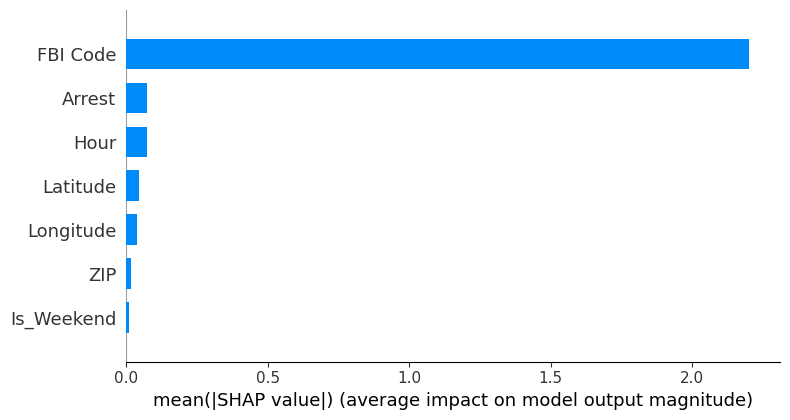

SHAP Summary Plot for Encoded_Crime_Type


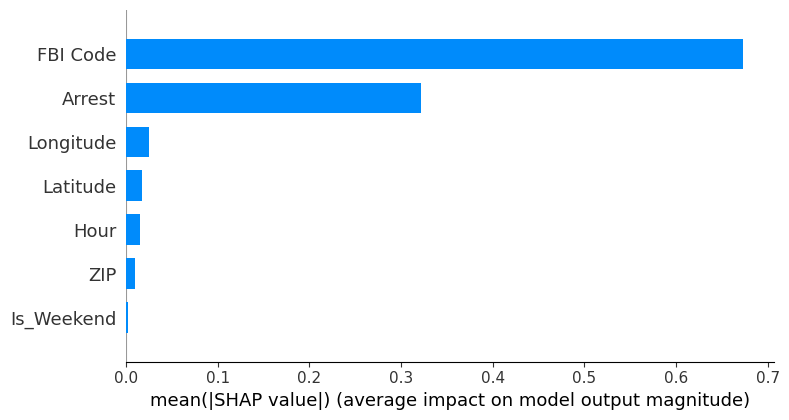

SHAP Summary Plot for Encoded_Crime_Severity


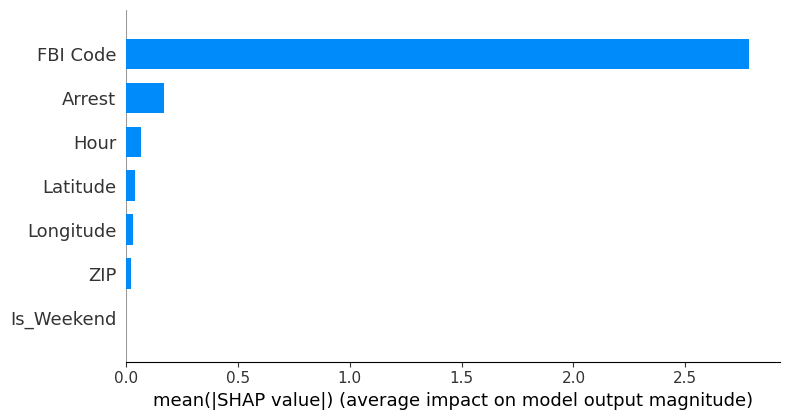

SHAP Summary Plot for Crime_Likelihood


In [ ]:
explainer = shap.TreeExplainer(xgb_model.estimators_[0])
shap_values = explainer.shap_values(X_val)

# Check the shape of shap_values and X_val
print("Shape of shap_values:", shap_values.shape)
print("Shape of X_val:", X_val.shape)

# Ensure feature_names length matches X_val columns
# The issue is likely due to the feature name size. Let us fix this
feature_names = selected_features
# or
# feature_names = X_val.columns.tolist()  # Use X_val columns as feature names
for i in range(len(target_columns)):  # Loop through each target variable
    shap.summary_plot(shap_values[:,:,i], X_val, feature_names=feature_names, plot_type = "bar") # plot_type = "bar" might work better in some use cases.
    print(f"SHAP Summary Plot for {target_columns[i]}")


In [ ]:
import joblib
import platform

joblib.dump(xgb_model, 'crime_prediction_model.pkl')



['crime_prediction_model.pkl']

In [ ]:
!pip install fastapi

In [ ]:
!pip install uvicorn

In [ ]:
df =ddf

In [ ]:
# from imblearn.over_sampling import SMOTE
# from sklearn.model_selection import train_test_split, RandomizedSearchCV
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import classification_report, confusion_matrix
# from sklearn.utils.class_weight import compute_class_weight
# import joblib

# # Selected Features (from SHAP analysis or prior feature engineering)
# selected_features = ['FBI Code', 'Arrest', 'Longitude', 'Latitude', 'Hour', 'ZIP', 'Is_Weekend']

# # Targets for the multi-task problem
# target_variables = ['Encoded_Crime_Type', 'Encoded_Crime_Severity', 'Crime_Likelihood']

# # Initialize SMOTE
# smote = SMOTE(random_state=42)

# # Define hyperparameter grid for RandomizedSearchCV
# param_dist = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [10, 20, 30, None],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4]
# }

# # Dictionary to store trained models and their reports
# models = {}
# reports = {}

# # Process each target variable
# for target in target_variables:
#     print(f"Processing target: {target}")

#     # Split data
#     X = df[selected_features]
#     y = df[target]

#     # Handle class imbalance using SMOTE
#     X_resampled, y_resampled = smote.fit_resample(X, y)

#     # Train-test split
#     X_train, X_test, y_train, y_test = train_test_split(
#         X_resampled, y_resampled, test_size=0.3, random_state=42
#     )

#     # Compute class weights
#     class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
#     class_weight_dict = dict(enumerate(class_weights))

#     # Initialize Random Forest Classifier with class weights
#     rf = RandomForestClassifier(random_state=42, n_jobs=2, class_weight=class_weight_dict)

#     # Hyperparameter tuning using RandomizedSearchCV
#     random_search = RandomizedSearchCV(
#         rf, param_distributions=param_dist, n_iter=50, scoring='f1_macro', cv=3, verbose=2, n_jobs=4
#     )
#     random_search.fit(X_train, y_train)

#     # Best model
#     best_rf = random_search.best_estimator_

#     # Evaluate the model
#     y_pred = best_rf.predict(X_test)
#     print(f"Classification Report for {target}:")
#     report = classification_report(y_test, y_pred, output_dict=True)
#     print(classification_report(y_test, y_pred))

#     # Confusion Matrix
#     conf_matrix = confusion_matrix(y_test, y_pred)
#     print(f"Confusion Matrix for {target}:\n", conf_matrix)

#     # Save model and report
#     models[target] = best_rf
#     reports[target] = report

#     # Save the trained model for deployment
#     joblib.dump(best_rf, f"{target}_model.pkl")

# print("Training completed for all target variables.")

# # Optionally, save reports for further analysis
# import json
# with open("model_reports.json", "w") as f:
#     json.dump(reports, f)

# # Example SHAP Analysis for Encoded_Crime_Type
# import shap

# explainer = shap.TreeExplainer(models['Encoded_Crime_Type'])
# shap_values = explainer.shap_values(X_test)

# # SHAP Summary Plot
# shap.summary_plot(shap_values, X_test, feature_names=selected_features)


Processing target: Encoded_Crime_Type
Fitting 3 folds for each of 50 candidates, totalling 150 fits


KeyboardInterrupt: 

In [ ]:
!pip install optuna

In [ ]:
import optuna
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_score
# Step 1: Data Preparation
# Assuming df is your dataset with features and target
selected_features = ['FBI Code', 'Arrest', 'Longitude', 'Latitude', 'Hour', 'ZIP', 'Is_Weekend']
target_variable = 'Encoded_Crime_Type'  # Replace with other targets as needed

X = df[selected_features].compute()  # Convert Dask DataFrame to Pandas DataFrame
y = df[target_variable].compute()  # Convert Dask Series to Pandas Series

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

def objective(trial):
    # Suggest hyperparameters with narrower ranges
    param = {
        "objective": "multiclass",
        "num_class": len(np.unique(y)),
        "boosting_type": "gbdt",
        "learning_rate": trial.suggest_float("learning_rate", 0.05, 0.2),
        "num_leaves": trial.suggest_int("num_leaves", 50, 100),
        "max_depth": trial.suggest_int("max_depth", 5, 10),
        "min_child_samples": trial.suggest_int("min_data_in_leaf", 10, 30),
        "reg_alpha": trial.suggest_float("lambda_l1", 0.0, 5.0),
        "reg_lambda": trial.suggest_float("lambda_l2", 0.0, 5.0),
        "subsample": trial.suggest_float("bagging_fraction", 0.6, 0.9),
        "colsample_bytree": trial.suggest_float("feature_fraction", 0.6, 0.9),
    }

    # Create LGBMClassifier with suggested parameters
    model = LGBMClassifier(**param, random_state=42, n_jobs=2)

    # Perform 3-fold cross-validation
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring="f1_macro", n_jobs=-1)
    return np.mean(scores)

# Optimize with fewer trials and folds
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)  # Reduce number of trials

# Best parameters
print("Best Hyperparameters:", study.best_params)

# Corrected Step 4: Train Final Model with Best Parameters
best_params = study.best_params
best_params["objective"] = "multiclass"
best_params["num_class"] = len(np.unique(y))
best_params["metric"] = "multi_logloss"

# Add `valid_sets` to allow early stopping
train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_test, label=y_test)

# Train the model with early stopping using callbacks
final_model = lgb.train(
    params=best_params,                  # Use best hyperparameters from Optuna
    train_set=train_data,                # Training data
    valid_sets=[valid_data],             # Validation data
    num_boost_round=1000,                # Maximum boosting rounds
    callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(10)],  # Early stopping callback, log_evaluation for verbose_eval
)
# Evaluate the final model
y_pred = final_model.predict(X_test, num_iteration=final_model.best_iteration)
y_pred_classes = np.argmax(y_pred, axis=1)

# Print F1 Score
print("Final Model F1 Score:", f1_score(y_test, y_pred_classes, average="macro"))

# Save the trained model for future use
import joblib
joblib.dump(final_model, "final_lgbm_model.pkl")


# SHAP Analysis for Explainability
explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, feature_names=selected_features)



[I 2024-12-03 19:54:12,799] A new study created in memory with name: no-name-f5f7a00a-d25e-4c24-8cc8-c8d77d18205a
[I 2024-12-03 19:55:04,754] Trial 0 finished with value: 0.7455315339942574 and parameters: {'learning_rate': 0.19128631709165567, 'num_leaves': 82, 'max_depth': 8, 'min_data_in_leaf': 14, 'lambda_l1': 1.130970005305667, 'lambda_l2': 1.8103301355612167, 'bagging_fraction': 0.7883321096471942, 'feature_fraction': 0.7973408030719855}. Best is trial 0 with value: 0.7455315339942574.
[I 2024-12-03 19:55:51,758] Trial 1 finished with value: 0.7505136927364173 and parameters: {'learning_rate': 0.06311042855309518, 'num_leaves': 61, 'max_depth': 9, 'min_data_in_leaf': 17, 'lambda_l1': 1.1277333389279702, 'lambda_l2': 1.4141011544566102, 'bagging_fraction': 0.6170214432553048, 'feature_fraction': 0.6765288712919607}. Best is trial 1 with value: 0.7505136927364173.
[I 2024-12-03 19:56:43,251] Trial 2 finished with value: 0.7427631850202436 and parameters: {'learning_rate': 0.1854156

Best Hyperparameters: {'learning_rate': 0.09205111482731662, 'num_leaves': 72, 'max_depth': 10, 'min_data_in_leaf': 28, 'lambda_l1': 0.9614256151828326, 'lambda_l2': 2.8598873542920984, 'bagging_fraction': 0.712104335955208, 'feature_fraction': 0.862939295639373}
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.092253 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 624
[LightGBM] [Info] Number of data points in the train set: 1311606, number of used features: 7
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -4.262264
[LightGBM] [Info] Start training from score -7.221915
[LightGBM] [Info] Start training from score -2.709863
[LightGBM] [Info] Start training from score -0.637667
[LightG

In [ ]:
import optuna
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_score
import joblib
# List of target variables
selected_features = ['FBI Code', 'Arrest', 'Longitude', 'Latitude', 'Hour', 'ZIP', 'Is_Weekend']

target_variables = ['Encoded_Crime_Type', 'Crime_Likelihood', 'Encoded_Crime_Severity']

# Dictionary to store results for each target variable
results = {}

for target_variable in target_variables:
    print(f"Processing target variable: {target_variable}")
    X = df[selected_features].compute()
    # Prepare data for the current target
    y = df[target_variable].compute()  # Convert Dask Series to Pandas Series
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )

    # ----> Apply Label Encoding after the train-test split <----
    encoder = LabelEncoder()
    X_train['FBI Code'] = encoder.fit_transform(X_train['FBI Code'].astype(str))
    X_test['FBI Code'] = encoder.transform(X_test['FBI Code'].astype(str))


    # Define objective function for Optuna
    def objective(trial):
        param = {
            "objective": "multiclass",
            "num_class": len(np.unique(y)),
            "boosting_type": "gbdt",
            "learning_rate": trial.suggest_float("learning_rate", 0.05, 0.2),
            "num_leaves": trial.suggest_int("num_leaves", 50, 100),
            "max_depth": trial.suggest_int("max_depth", 5, 10),
            "min_child_samples": trial.suggest_int("min_data_in_leaf", 10, 30),
            "reg_alpha": trial.suggest_float("lambda_l1", 0.0, 5.0),
            "reg_lambda": trial.suggest_float("lambda_l2", 0.0, 5.0),
            "subsample": trial.suggest_float("bagging_fraction", 0.6, 0.9),
            "colsample_bytree": trial.suggest_float("feature_fraction", 0.6, 0.9),
        }

        model = LGBMClassifier(**param, random_state=42, n_jobs=2)
        scores = cross_val_score(model, X_train, y_train, cv=3, scoring="f1_macro", n_jobs=4)
        return np.mean(scores)

    # Optimize hyperparameters using Optuna
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=10)  # Adjust n_trials as needed

    # Best parameters
    best_params = study.best_params
    best_params["objective"] = "multiclass"
    best_params["num_class"] = len(np.unique(y))
    best_params["metric"] = "multi_logloss"

    # Train final model
    train_data = lgb.Dataset(X_train, label=y_train)
    valid_data = lgb.Dataset(X_test, label=y_test)

    final_model = lgb.train(
        params=best_params,
        train_set=train_data,
        valid_sets=[valid_data],
        num_boost_round=1000,
        callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(10)],
    )

    # Evaluate the final model
    y_pred = final_model.predict(X_test, num_iteration=final_model.best_iteration)
    y_pred_classes = np.argmax(y_pred, axis=1)
    f1 = f1_score(y_test, y_pred_classes, average="macro")
    print(f"F1 Score for {target_variable}: {f1}")

    # Save the model
    model_filename = f"{target_variable}_lgbm_model.pkl"
    joblib.dump(final_model, model_filename)
    print(f"Model saved as {model_filename}")

    # SHAP analysis
    explainer = shap.TreeExplainer(final_model)
    shap_values = explainer.shap_values(X_test)
    shap.summary_plot(shap_values, X_test, feature_names=selected_features)

    # Store results for the current target variable
    results[target_variable] = {
        "f1_score": f1,
        "best_params": best_params,
        "model": final_model,
    }


# Summary of results
for target, res in results.items():
    print(f"Results for {target}:")
    print(f"  F1 Score: {res['f1_score']}")
    print(f"  Best Parameters: {res['best_params']}")


Processing target variable: Encoded_Crime_Type


[I 2024-12-04 01:30:49,024] A new study created in memory with name: no-name-facca880-a2e3-492a-9ebe-c3593091a270
[I 2024-12-04 01:31:32,928] Trial 0 finished with value: 0.8193018331480427 and parameters: {'learning_rate': 0.05059917575963015, 'num_leaves': 58, 'max_depth': 8, 'min_data_in_leaf': 11, 'lambda_l1': 0.27812559761782485, 'lambda_l2': 0.6901769655385864, 'bagging_fraction': 0.8579419191018964, 'feature_fraction': 0.7665556775084053}. Best is trial 0 with value: 0.8193018331480427.
[I 2024-12-04 01:32:21,948] Trial 1 finished with value: 0.8146788015760377 and parameters: {'learning_rate': 0.18972018580560096, 'num_leaves': 66, 'max_depth': 9, 'min_data_in_leaf': 25, 'lambda_l1': 4.300458166728784, 'lambda_l2': 4.715897462262268, 'bagging_fraction': 0.7665214034798493, 'feature_fraction': 0.8731798425646645}. Best is trial 0 with value: 0.8193018331480427.
[I 2024-12-04 01:33:07,994] Trial 2 finished with value: 0.8185505691096934 and parameters: {'learning_rate': 0.1542378

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029476 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 625
[LightGBM] [Info] Number of data points in the train set: 1311606, number of used features: 7
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -4.262264
[LightGBM] [Info] Start training from score -7.221915
[LightGBM] [Info] Start training from score -2.709863
[LightGBM] [Info] Start training from score -0.637667
[LightGBM] [Info] Start training from score -4.762737
[LightGBM] [Info] Start training from score -5.328351
[LightGBM] [Info] Start training from score -3.353785
[LightGBM] [Info] Start training from score -1.073636
[LightGBM] [Warning] No further splits with positive ga

In [ ]:
import optuna
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_score
import joblib
# List of target variables
selected_features = ['FBI Code', 'Arrest', 'Longitude', 'Latitude', 'Hour', 'ZIP', 'Is_Weekend']

target_variables = 'Crime_Likelihood'

# Dictionary to store results for each target variable
results = {}


print(f"Processing target variable: {target_variables}")
X = df[selected_features].compute()
# Prepare data for the current target
y = df[target_variables].compute()  # Convert Dask Series to Pandas Series
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# ----> Apply Label Encoding after the train-test split <----
encoder = LabelEncoder()
X_train['FBI Code'] = encoder.fit_transform(X_train['FBI Code'].astype(str))
X_test['FBI Code'] = encoder.transform(X_test['FBI Code'].astype(str))


# Define objective function for Optuna
def objective(trial):
    param = {
        "objective": "multiclass",
        "num_class": len(np.unique(y)),
        "boosting_type": "gbdt",
        "learning_rate": trial.suggest_float("learning_rate", 0.05, 0.2),
        "num_leaves": trial.suggest_int("num_leaves", 50, 100),
        "max_depth": trial.suggest_int("max_depth", 5, 10),
        "min_child_samples": trial.suggest_int("min_data_in_leaf", 10, 30),
        "reg_alpha": trial.suggest_float("lambda_l1", 0.0, 5.0),
        "reg_lambda": trial.suggest_float("lambda_l2", 0.0, 5.0),
        "subsample": trial.suggest_float("bagging_fraction", 0.6, 0.9),
        "colsample_bytree": trial.suggest_float("feature_fraction", 0.6, 0.9),
    }

    model = LGBMClassifier(**param, random_state=42, n_jobs=2)
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring="f1_macro", n_jobs=4)
    return np.mean(scores)

# Optimize hyperparameters using Optuna
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)  # Adjust n_trials as needed

# Best parameters
best_params = study.best_params
best_params["objective"] = "multiclass"
best_params["num_class"] = len(np.unique(y))
best_params["metric"] = "multi_logloss"

# Train final model
train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_test, label=y_test)

final_model = lgb.train(
    params=best_params,
    train_set=train_data,
    valid_sets=[valid_data],
    num_boost_round=1000,
    callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(10)],
)

# Evaluate the final model
y_pred = final_model.predict(X_test, num_iteration=final_model.best_iteration)
y_pred_classes = np.argmax(y_pred, axis=1)
f1 = f1_score(y_test, y_pred_classes, average="macro")
print(f"F1 Score for {target_variables}: {f1}")

# Save the model
model_filename = f"{target_variables}_lgbm_model.pkl"
joblib.dump(final_model, model_filename)
print(f"Model saved as {model_filename}")


# Store results for the current target variable
results[target_variables] = {
    "f1_score": f1,
    "best_params": best_params,
    "model": final_model,
}


# Summary of results
for target, res in results.items():
    print(f"Results for {target}:")
    print(f"  F1 Score: {res['f1_score']}")
    print(f"  Best Parameters: {res['best_params']}")


Processing target variable: Crime_Likelihood


[I 2024-12-04 01:55:07,929] A new study created in memory with name: no-name-6dd6a23e-7d71-445a-9d82-3be4a3b6091b
[I 2024-12-04 01:55:24,134] Trial 0 finished with value: 0.8866460217894359 and parameters: {'learning_rate': 0.1980195481663622, 'num_leaves': 83, 'max_depth': 6, 'min_data_in_leaf': 14, 'lambda_l1': 2.6246461230109364, 'lambda_l2': 4.515699747636904, 'bagging_fraction': 0.8527133244157614, 'feature_fraction': 0.6598175077440569}. Best is trial 0 with value: 0.8866460217894359.
[I 2024-12-04 01:55:41,083] Trial 1 finished with value: 0.8872776052064134 and parameters: {'learning_rate': 0.19184964360354995, 'num_leaves': 78, 'max_depth': 7, 'min_data_in_leaf': 15, 'lambda_l1': 1.183311394330913, 'lambda_l2': 3.9011135333333105, 'bagging_fraction': 0.7935866414730464, 'feature_fraction': 0.685608216155109}. Best is trial 1 with value: 0.8872776052064134.
[I 2024-12-04 01:55:56,853] Trial 2 finished with value: 0.8872519836198115 and parameters: {'learning_rate': 0.1484090756

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.033983 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 625
[LightGBM] [Info] Number of data points in the train set: 1311606, number of used features: 7
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.614666
[LightGBM] [Info] Start training from score -0.778317
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warnin

In [ ]:
import optuna
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_score
import joblib
# List of target variables
selected_features = ['FBI Code', 'Arrest', 'Longitude', 'Latitude', 'Hour', 'ZIP', 'Is_Weekend']

target_variables = 'Encoded_Crime_Severity'

# Dictionary to store results for each target variable
results = {}


print(f"Processing target variable: {target_variables}")
X = df[selected_features].compute()
# Prepare data for the current target
y = df[target_variables].compute()  # Convert Dask Series to Pandas Series
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# ----> Apply Label Encoding after the train-test split <----
encoder = LabelEncoder()
X_train['FBI Code'] = encoder.fit_transform(X_train['FBI Code'].astype(str))
X_test['FBI Code'] = encoder.transform(X_test['FBI Code'].astype(str))


# Define objective function for Optuna
def objective(trial):
    param = {
        "objective": "multiclass",
        "num_class": len(np.unique(y)),
        "boosting_type": "gbdt",
        "learning_rate": trial.suggest_float("learning_rate", 0.05, 0.2),
        "num_leaves": trial.suggest_int("num_leaves", 50, 100),
        "max_depth": trial.suggest_int("max_depth", 5, 10),
        "min_child_samples": trial.suggest_int("min_data_in_leaf", 10, 30),
        "reg_alpha": trial.suggest_float("lambda_l1", 0.0, 5.0),
        "reg_lambda": trial.suggest_float("lambda_l2", 0.0, 5.0),
        "subsample": trial.suggest_float("bagging_fraction", 0.6, 0.9),
        "colsample_bytree": trial.suggest_float("feature_fraction", 0.6, 0.9),
    }

    model = LGBMClassifier(**param, random_state=42, n_jobs=2)
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring="f1_macro", n_jobs=4)
    return np.mean(scores)

# Optimize hyperparameters using Optuna
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)  # Adjust n_trials as needed

# Best parameters
best_params = study.best_params
best_params["objective"] = "multiclass"
best_params["num_class"] = len(np.unique(y))
best_params["metric"] = "multi_logloss"

# Train final model
train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_test, label=y_test)

final_model = lgb.train(
    params=best_params,
    train_set=train_data,
    valid_sets=[valid_data],
    num_boost_round=1000,
    callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(10)],
)

# Evaluate the final model
y_pred = final_model.predict(X_test, num_iteration=final_model.best_iteration)
y_pred_classes = np.argmax(y_pred, axis=1)
f1 = f1_score(y_test, y_pred_classes, average="macro")
print(f"F1 Score for {target_variables}: {f1}")

# Save the model
model_filename = f"{target_variables}_lgbm_model.pkl"
joblib.dump(final_model, model_filename)
print(f"Model saved as {model_filename}")


# Store results for the current target variable
results[target_variables] = {
    "f1_score": f1,
    "best_params": best_params,
    "model": final_model,
}


# Summary of results
for target, res in results.items():
    print(f"Results for {target}:")
    print(f"  F1 Score: {res['f1_score']}")
    print(f"  Best Parameters: {res['best_params']}")


Processing target variable: Encoded_Crime_Severity


[I 2024-12-04 01:59:09,657] A new study created in memory with name: no-name-c8de34d9-05f8-4816-93ab-912d08fb8e4c
[I 2024-12-04 01:59:25,834] Trial 0 finished with value: 0.9070482295960502 and parameters: {'learning_rate': 0.1980973437901133, 'num_leaves': 67, 'max_depth': 9, 'min_data_in_leaf': 28, 'lambda_l1': 1.1350171112788536, 'lambda_l2': 0.26158403252460327, 'bagging_fraction': 0.7521570824081378, 'feature_fraction': 0.8875880622138326}. Best is trial 0 with value: 0.9070482295960502.
[I 2024-12-04 01:59:40,038] Trial 1 finished with value: 0.9048647254106434 and parameters: {'learning_rate': 0.06481856640854267, 'num_leaves': 57, 'max_depth': 5, 'min_data_in_leaf': 27, 'lambda_l1': 3.5946027225560906, 'lambda_l2': 0.303693064019101, 'bagging_fraction': 0.8957450032067862, 'feature_fraction': 0.7282975634994477}. Best is trial 0 with value: 0.9070482295960502.
[I 2024-12-04 01:59:57,386] Trial 2 finished with value: 0.9068870972938865 and parameters: {'learning_rate': 0.0848092

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.031599 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 625
[LightGBM] [Info] Number of data points in the train set: 1311606, number of used features: 7
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -1.019694
[LightGBM] [Info] Start training from score -2.698936
[LightGBM] [Info] Start training from score -0.558585
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

## Best Parameters:
{'learning_rate': 0.1629, 'num_leaves': 57, 'max_depth': 9, 'min_data_in_leaf': 30,
'lambda_l1': 2.0656, 'lambda_l2': 3.0661, 'bagging_fraction': 0.8653, 'feature_fraction': 0.7307}


Results:

- Encoded_Crime_Severity: 0.9074 → Excellent predictive accuracy.
- Crime_Likelihood: 0.8876 → Very good predictive accuracy.
- Encoded_Crime_Type: 0.8256 → Good predictive accuracy but slightly lower than the others.


Encoded_Crime_Severity is the easiest to predict, with the highest F1 score.
Encoded_Crime_Type is more complex, reflected by the lower F1 score.


### Real Time Prediction